In [1]:
#!pip3 install torch torchvision

In [2]:
# %%writefile vanilla_gan.py
!mkdir outputs
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib

from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

import pandas as pd

matplotlib.style.use('ggplot')

In [3]:
# learning parameters
batch_size = 512
epochs = 30
sample_size = 64 # fixed sample size
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# train_dataset = dsets.MNIST(root='./data/', train=True, download=True, transform=transform)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)

# MNIST Dataset
train_data = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
train_data, valid_data = torch.utils.data.random_split(train_data, [50000, 10000])
test_data = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)



Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...



/Users/shwetambari/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1603740477510/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [5]:
# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [6]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),

            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)

# print('##### GENERATOR #####')
# print(generator)
# print('######################')

# print('\n##### DISCRIMINATOR #####')
# print(discriminator)
# print('######################')

In [7]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

# loss function
criterion = nn.BCELoss()


# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)

# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)

    optimizer.zero_grad()

    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)

    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)


    loss_real.backward()
    loss_fake.backward()
    optimizer.step()

    return loss_real + loss_fake

# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)

    optimizer.zero_grad()

    output = discriminator(data_fake)
    loss = criterion(output, real_label)

    loss.backward()
    optimizer.step()

    return loss    



In [9]:
# create the noise vector
noise = create_noise(sample_size, nz)

generator.train()
discriminator.train()

train_losses_g = [] # to store generator loss after each epoch
train_losses_d = [] # to store discriminator loss after each epoch
#train_images = [] # to store images generatd by the generator

valid_losses_g = [] # to store generator loss after each epoch
valid_losses_d = [] # to store discriminator loss after each epoch
valid_images = [] # to store images generatd by the generator


for epoch in range(epochs):
    
    loss_g = 0.0
    loss_d = 0.0
    
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # run the discriminator for k number of steps
        for step in range(k):
            data_fake = generator(create_noise(b_size, nz)).detach()
            data_real = image
            # train the discriminator network
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)
    
    
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    train_losses_g.append(epoch_loss_g)
    train_losses_d.append(epoch_loss_d)
    print(f"Epoch {epoch} of {epochs}")
    print("Training")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")
    
    
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(valid_loader), total=int(len(valid_data)/valid_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # run the discriminator for k number of steps
        for step in range(k):
            data_fake = generator(create_noise(b_size, nz)).detach()
            data_real = image
            # train the discriminator network
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)
    
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    valid_losses_g.append(epoch_loss_g)
    valid_losses_d.append(epoch_loss_d)

    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    # make the images as grid
    generated_img = make_grid(generated_img)
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch}.png")
    valid_images.append(generated_img)
    
    #print(f"Epoch {epoch} of {epochs}")
    print("Validation")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

print('DONE TRAINING')
#torch.save(generator.state_dict(), 'outputs/generator.pth')

# save the generated images as GIF file
# imgs = [np.array(to_pil_image(img)) for img in images]
# imageio.mimsave('outputs/generator_images.gif', imgs)

pd.DataFrame(train_losses_d).to_csv('train_dis.csv')
pd.DataFrame(train_losses_g).to_csv('train_gen.csv')
pd.DataFrame(valid_losses_d).to_csv('valid_dis.csv')
pd.DataFrame(valid_losses_g).to_csv('valid_gen.csv')

98it [00:26,  3.66it/s]                        
  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 0 of 30
Training
Generator loss: 1.42801309, Discriminator loss: 1.58726716


20it [00:05,  3.76it/s]                        
  0%|          | 0/97 [00:00<?, ?it/s]

Validation
Generator loss: 1.61558294, Discriminator loss: 1.21806943


98it [00:27,  3.58it/s]                        
  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 1 of 30
Training
Generator loss: 1.06979072, Discriminator loss: 1.35381532


20it [00:05,  3.82it/s]                        
  0%|          | 0/97 [00:00<?, ?it/s]

Validation
Generator loss: 1.41842866, Discriminator loss: 1.10889018


98it [00:27,  3.59it/s]                        
  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 2 of 30
Training
Generator loss: 0.87052631, Discriminator loss: 1.39169443


20it [00:05,  3.60it/s]                        
  0%|          | 0/97 [00:00<?, ?it/s]

Validation
Generator loss: 1.68862772, Discriminator loss: 1.11813509


98it [00:26,  3.72it/s]                        
  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 3 of 30
Training
Generator loss: 0.72785008, Discriminator loss: 1.35599303


20it [00:05,  3.65it/s]                        
  0%|          | 0/97 [00:00<?, ?it/s]

Validation
Generator loss: 1.03118408, Discriminator loss: 1.13821185


98it [00:25,  3.87it/s]                        
  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 4 of 30
Training
Generator loss: 1.05860579, Discriminator loss: 1.30535436


20it [00:05,  3.98it/s]                        
  0%|          | 0/97 [00:00<?, ?it/s]

Validation
Generator loss: 0.82944751, Discriminator loss: 1.26074636


98it [00:25,  3.90it/s]                        
  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 5 of 30
Training
Generator loss: 1.38342929, Discriminator loss: 1.22080791


20it [00:05,  3.98it/s]                        
  0%|          | 0/97 [00:00<?, ?it/s]

Validation
Generator loss: 1.38138413, Discriminator loss: 0.97681516


98it [00:24,  3.93it/s]                        
  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 6 of 30
Training
Generator loss: 2.20229745, Discriminator loss: 0.93394661


20it [00:05,  3.98it/s]                        
  0%|          | 0/97 [00:00<?, ?it/s]

Validation
Generator loss: 2.45226097, Discriminator loss: 0.31179208


98it [00:25,  3.91it/s]                        
  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 7 of 30
Training
Generator loss: 2.65779924, Discriminator loss: 0.88514900


20it [00:05,  3.96it/s]                        
  0%|          | 0/97 [00:00<?, ?it/s]

Validation
Generator loss: 1.27260005, Discriminator loss: 1.69909382


98it [00:25,  3.92it/s]                        
  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 8 of 30
Training
Generator loss: 2.72360706, Discriminator loss: 0.74978757


20it [00:05,  3.96it/s]                        
  0%|          | 0/97 [00:00<?, ?it/s]

Validation
Generator loss: 5.49986172, Discriminator loss: 1.79587710


98it [00:25,  3.92it/s]                        
  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 9 of 30
Training
Generator loss: 3.39844847, Discriminator loss: 0.66084605


20it [00:05,  3.96it/s]                        
  0%|          | 0/97 [00:00<?, ?it/s]

Validation
Generator loss: 2.89333916, Discriminator loss: 0.31264743


98it [00:24,  3.92it/s]                        
  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 10 of 30
Training
Generator loss: 3.47136259, Discriminator loss: 0.81600362


20it [00:05,  3.97it/s]                        
  0%|          | 0/97 [00:00<?, ?it/s]

Validation
Generator loss: 2.29810643, Discriminator loss: 1.28718281


98it [00:25,  3.91it/s]                        
  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 11 of 30
Training
Generator loss: 2.30435443, Discriminator loss: 0.91412944


20it [00:05,  3.97it/s]                        
  0%|          | 0/97 [00:00<?, ?it/s]

Validation
Generator loss: 2.59480357, Discriminator loss: 0.45933798


98it [00:25,  3.92it/s]                        
  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 12 of 30
Training
Generator loss: 2.80107927, Discriminator loss: 0.31091216


20it [00:05,  3.96it/s]                        
  0%|          | 0/97 [00:00<?, ?it/s]

Validation
Generator loss: 3.22920847, Discriminator loss: 0.20592614


98it [00:27,  3.54it/s]                        
  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 13 of 30
Training
Generator loss: 3.32950425, Discriminator loss: 1.05244112


20it [00:06,  3.23it/s]                        
  0%|          | 0/97 [00:00<?, ?it/s]

Validation
Generator loss: 0.91187274, Discriminator loss: 1.30651295


98it [00:30,  3.21it/s]                        
  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 14 of 30
Training
Generator loss: 2.30314064, Discriminator loss: 0.77039260


20it [00:05,  3.99it/s]                        
  0%|          | 0/97 [00:00<?, ?it/s]

Validation
Generator loss: 2.89747787, Discriminator loss: 0.60942721


98it [00:25,  3.91it/s]                        
  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 15 of 30
Training
Generator loss: 2.26190734, Discriminator loss: 0.79191661


20it [00:05,  3.99it/s]                        
  0%|          | 0/97 [00:00<?, ?it/s]

Validation
Generator loss: 3.34722090, Discriminator loss: 0.28756246


98it [00:24,  3.92it/s]                        
  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 16 of 30
Training
Generator loss: 2.01810551, Discriminator loss: 0.88188165


20it [00:04,  4.01it/s]                        
  0%|          | 0/97 [00:00<?, ?it/s]

Validation
Generator loss: 2.36382842, Discriminator loss: 0.46984789


98it [00:25,  3.78it/s]                        
  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 17 of 30
Training
Generator loss: 2.22233367, Discriminator loss: 0.70431840


20it [00:06,  3.27it/s]                        
  0%|          | 0/97 [00:00<?, ?it/s]

Validation
Generator loss: 2.17973161, Discriminator loss: 0.70304382


98it [00:31,  3.12it/s]                        
  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 18 of 30
Training
Generator loss: 1.81999755, Discriminator loss: 0.66907829


20it [00:06,  2.94it/s]                        
  0%|          | 0/97 [00:00<?, ?it/s]

Validation
Generator loss: 2.69579601, Discriminator loss: 0.76125330


98it [00:26,  3.76it/s]                        
  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 19 of 30
Training
Generator loss: 2.24581909, Discriminator loss: 0.61227423


20it [00:05,  3.97it/s]                        
  0%|          | 0/97 [00:00<?, ?it/s]

Validation
Generator loss: 2.37975574, Discriminator loss: 0.75983620


98it [00:25,  3.90it/s]                        
  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 20 of 30
Training
Generator loss: 2.42143273, Discriminator loss: 0.50368643


20it [00:05,  3.99it/s]                        
  0%|          | 0/97 [00:00<?, ?it/s]

Validation
Generator loss: 3.26398396, Discriminator loss: 0.48063573


98it [00:25,  3.89it/s]                        
  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 21 of 30
Training
Generator loss: 2.60038996, Discriminator loss: 0.71967161


20it [00:05,  3.96it/s]                        
  0%|          | 0/97 [00:00<?, ?it/s]

Validation
Generator loss: 2.05636144, Discriminator loss: 1.13414860


98it [00:25,  3.91it/s]                        
  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 22 of 30
Training
Generator loss: 2.03340816, Discriminator loss: 0.77962154


20it [00:05,  3.95it/s]                        
  0%|          | 0/97 [00:00<?, ?it/s]

Validation
Generator loss: 2.14484477, Discriminator loss: 0.61398882


98it [00:25,  3.89it/s]                        
  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 23 of 30
Training
Generator loss: 2.40172505, Discriminator loss: 0.57369947


20it [00:05,  3.91it/s]                        
  0%|          | 0/97 [00:00<?, ?it/s]

Validation
Generator loss: 2.61063814, Discriminator loss: 1.01982391


98it [00:27,  3.60it/s]                        
  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 24 of 30
Training
Generator loss: 2.08247638, Discriminator loss: 0.84182149


20it [00:05,  3.97it/s]                        
  0%|          | 0/97 [00:00<?, ?it/s]

Validation
Generator loss: 3.03486991, Discriminator loss: 0.77114975


98it [00:25,  3.90it/s]                        
  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 25 of 30
Training
Generator loss: 2.24184656, Discriminator loss: 0.83543819


20it [00:05,  3.97it/s]                        
  0%|          | 0/97 [00:00<?, ?it/s]

Validation
Generator loss: 1.93896139, Discriminator loss: 1.00194192


98it [00:25,  3.90it/s]                        
  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 26 of 30
Training
Generator loss: 1.94755363, Discriminator loss: 0.75419301


20it [00:05,  3.56it/s]                        
  0%|          | 0/97 [00:00<?, ?it/s]

Validation
Generator loss: 2.01426005, Discriminator loss: 0.81157219


98it [00:29,  3.33it/s]                        
  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 27 of 30
Training
Generator loss: 2.26361346, Discriminator loss: 0.65874618


20it [00:05,  3.93it/s]                        
  0%|          | 0/97 [00:00<?, ?it/s]

Validation
Generator loss: 2.77536297, Discriminator loss: 0.52757275


98it [00:25,  3.84it/s]                        
  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 28 of 30
Training
Generator loss: 2.31829667, Discriminator loss: 0.80451834


20it [00:05,  3.84it/s]                        
  0%|          | 0/97 [00:00<?, ?it/s]

Validation
Generator loss: 2.34850717, Discriminator loss: 0.78489798


98it [00:25,  3.88it/s]                        
  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 29 of 30
Training
Generator loss: 1.69929767, Discriminator loss: 0.93611538


20it [00:05,  3.91it/s]                        

Validation
Generator loss: 1.90106320, Discriminator loss: 0.82989329
DONE TRAINING


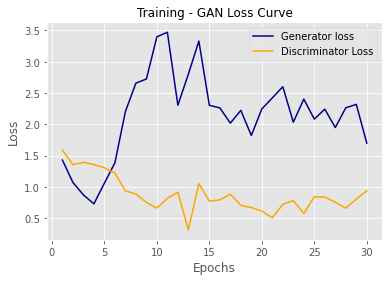

In [10]:
# plot and save the generator and discriminator loss
plt.figure()
epochs_plot = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
plt.plot(epochs_plot,train_losses_g, label='Generator loss', color = 'darkblue')
plt.plot(epochs_plot,train_losses_d, label='Discriminator Loss', color = 'orange')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.title("Training - GAN Loss Curve", fontsize=12)
plt.legend()
plt.savefig('train_mnist_gan.png')

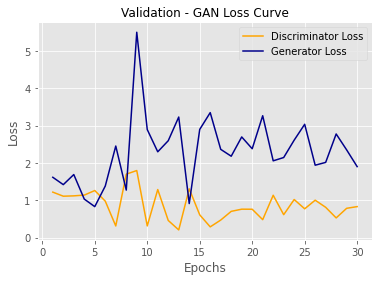

In [11]:
plt.figure()
epochs_plot = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
plt.plot(epochs_plot, valid_losses_d, label='Discriminator Loss', color = 'orange')
plt.plot(epochs_plot, valid_losses_g, label='Generator Loss', color = 'darkblue')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.title("Validation - GAN Loss Curve", fontsize=12)
plt.legend()
plt.savefig('valid_mnist_gan.png')

### Latent Interpolation

In [ ]:
def latent_interpolation(model_path, out_path, out_name, n_steps, imsize, start_num, end_num):
        
        full_model = load_model(model_path)
        embeddings = full_model.layers[1].get_weights()[0]

        generator = full_model.layers[-1]
        model = Model(generator.layers[0].input, generator.layers[-1].output)

        num = start_num
        countdown = start_num > end_num

        vectors = []
        alpha_values = np.linspace(0, 1, n_steps)

        start_idx = np.random.choice(np.where(self.y_train==num)[0])

        for _ in tqdm(range(abs(start_num-end_num))):
            latent_start = embeddings[start_idx]
            num = num - 1 if countdown else num + 1
            start_idx = np.random.choice(np.where(self.y_train==num)[0])
            latent_end = embeddings[start_idx]
            for alpha in alpha_values:
                vector = latent_start*(1-alpha) + latent_end*alpha
                vectors.append(vector)

        gen_imgs = model.predict(np.array(vectors))
        gen_imgs = np.uint8((0.5 * gen_imgs + 0.5) * 255)
        resized_imgs = np.zeros((gen_imgs.shape[0], imsize, imsize))
        for i in range(gen_imgs.shape[0]): 
            resized_imgs[i] = transform.resize(gen_imgs[i].squeeze(), (imsize, imsize))
        imageio.mimsave(os.path.join(out_path, out_name), resized_imgs)

In [ ]:
model_path = "model-250.h5"
out_path = "output"
out_name = "countdown.gif"
n_steps = 30
imsize = 28
start_num = 9 
end_num = 0

In [ ]:
latent_interpolation(model_path=model_path, out_path=out_path, out_name=out_name,n_steps=n_steps, imsize=imsize, start_num=start_num, end_num=end_num)